In [ ]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [ ]:
# Read csv file with sheet name
abdomen_df = pd.read_csv('/content/abdomen_df.csv')
brain_df = pd.read_csv('/content/brain_df.csv')
msk_df = pd.read_csv('/content/msk_df.csv')

In [ ]:
abdomen_df

,Protocol,Protocol_Name,Key_Word_Total,Description
0,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,fu MRI abd for ongoing surveillance of liver m...
1,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,Hx HCC ?
2,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,HBV HCC Follow up
3,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,"mri liver, CT for prostate cancer staging show..."
4,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,hypoattenuation lesions of liver noted on CT
...,...,...,...,...
108,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...,missing f/u of multicystic lesion at head of p...
109,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...,Follow up pancreatic cysts
110,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...,f/u of lesion on the pancreas was recommmended...
111,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...,"? lesion on pancreatic body seen on CT, rad re..."


In [ ]:
brain_df

,Protocol,Key_Word_Total,Description
0,1,Migraine Headache LOC dizzieness weakness Vomi...,"history of right hemicranial headache, r/o str..."
1,1,Migraine Headache LOC dizzieness weakness Vomi...,"history of chronic headaches, r/o seizure focus"
2,1,Migraine Headache LOC dizzieness weakness Vomi...,Increased frequency in migraine for the last 6...
3,1,Migraine Headache LOC dizzieness weakness Vomi...,"post traumatic headache for 1 year, please assess"
4,1,Migraine Headache LOC dizzieness weakness Vomi...,"early onset parkinsons in a young male, known ..."
...,...,...,...
86,54,nyd,"signs of NPH, radiographic correlation ? obstr..."
87,54,nyd,R/O brain stem stroke
88,54,nyd,R/O stroke possibly related to know >70%right ...
89,54,nyd,more forgetting and concerns about dementia fo...


In [ ]:
msk_df

,Protocol,Key_Word_Total,Description
0,1,acl pcl mcl lcl meniscus knee osteoid meniscal...,"fell, persistant anterior/medial pain"
1,1,acl pcl mcl lcl meniscus knee osteoid meniscal...,"pain on weight-bearing, tender suprapatellar a..."
2,1,acl pcl mcl lcl meniscus knee osteoid meniscal...,"giving way, locking, swelling R knee"
3,1,acl pcl mcl lcl meniscus knee osteoid meniscal...,medial meniscectomy and now locking knee? tear?
4,1,acl pcl mcl lcl meniscus knee osteoid meniscal...,ACL tear clinically
...,...,...,...
203,21,Mass osteochondroma enchondromas giant cell os...,28 female mass on lowerback mass vs lipoma
204,21,Mass osteochondroma enchondromas giant cell os...,"23 female sarcoma right thigh 2 years, recent ..."
205,21,Mass osteochondroma enchondromas giant cell os...,palpable mass on lt elbow. lipoma vs mass
206,21,Mass osteochondroma enchondromas giant cell os...,rt forearm mass growing. US was inconclusive ...


##***Target Variable: Abdomen***

In [ ]:
abdomen_df

,Protocol,Protocol_Name,Key_Word_Total,Description
0,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,fu MRI abd for ongoing surveillance of liver m...
1,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,Hx HCC ?
2,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,HBV HCC Follow up
3,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,"mri liver, CT for prostate cancer staging show..."
4,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...,hypoattenuation lesions of liver noted on CT
...,...,...,...,...
108,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...,missing f/u of multicystic lesion at head of p...
109,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...,Follow up pancreatic cysts
110,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...,f/u of lesion on the pancreas was recommmended...
111,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...,"? lesion on pancreatic body seen on CT, rad re..."


##***Step #1) Identify the Tie between protocols***


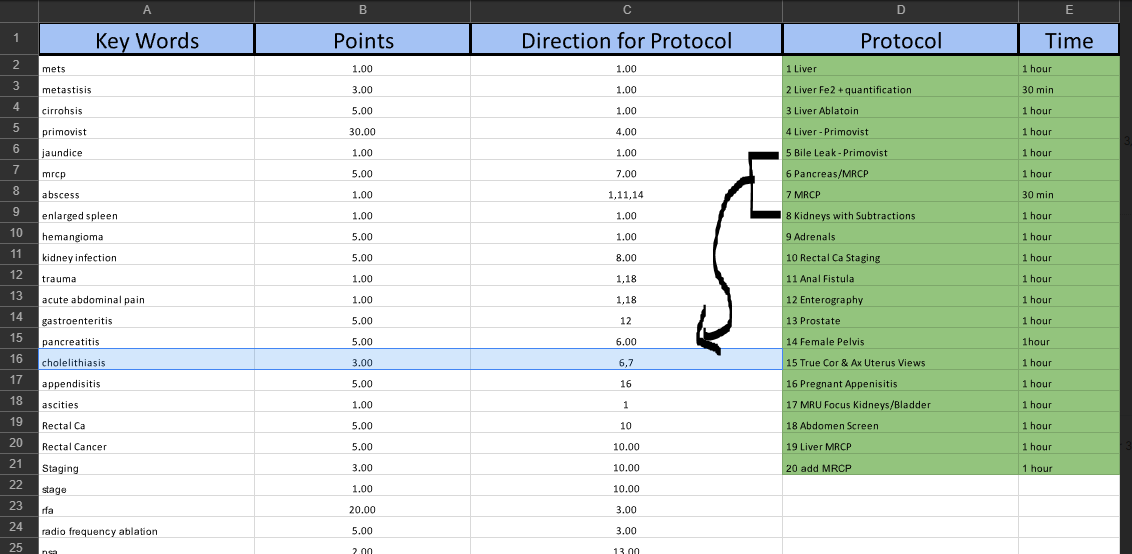


##***Step #2) Use the new descriptions to compare with the bag of words & past diagnosis descriptions***

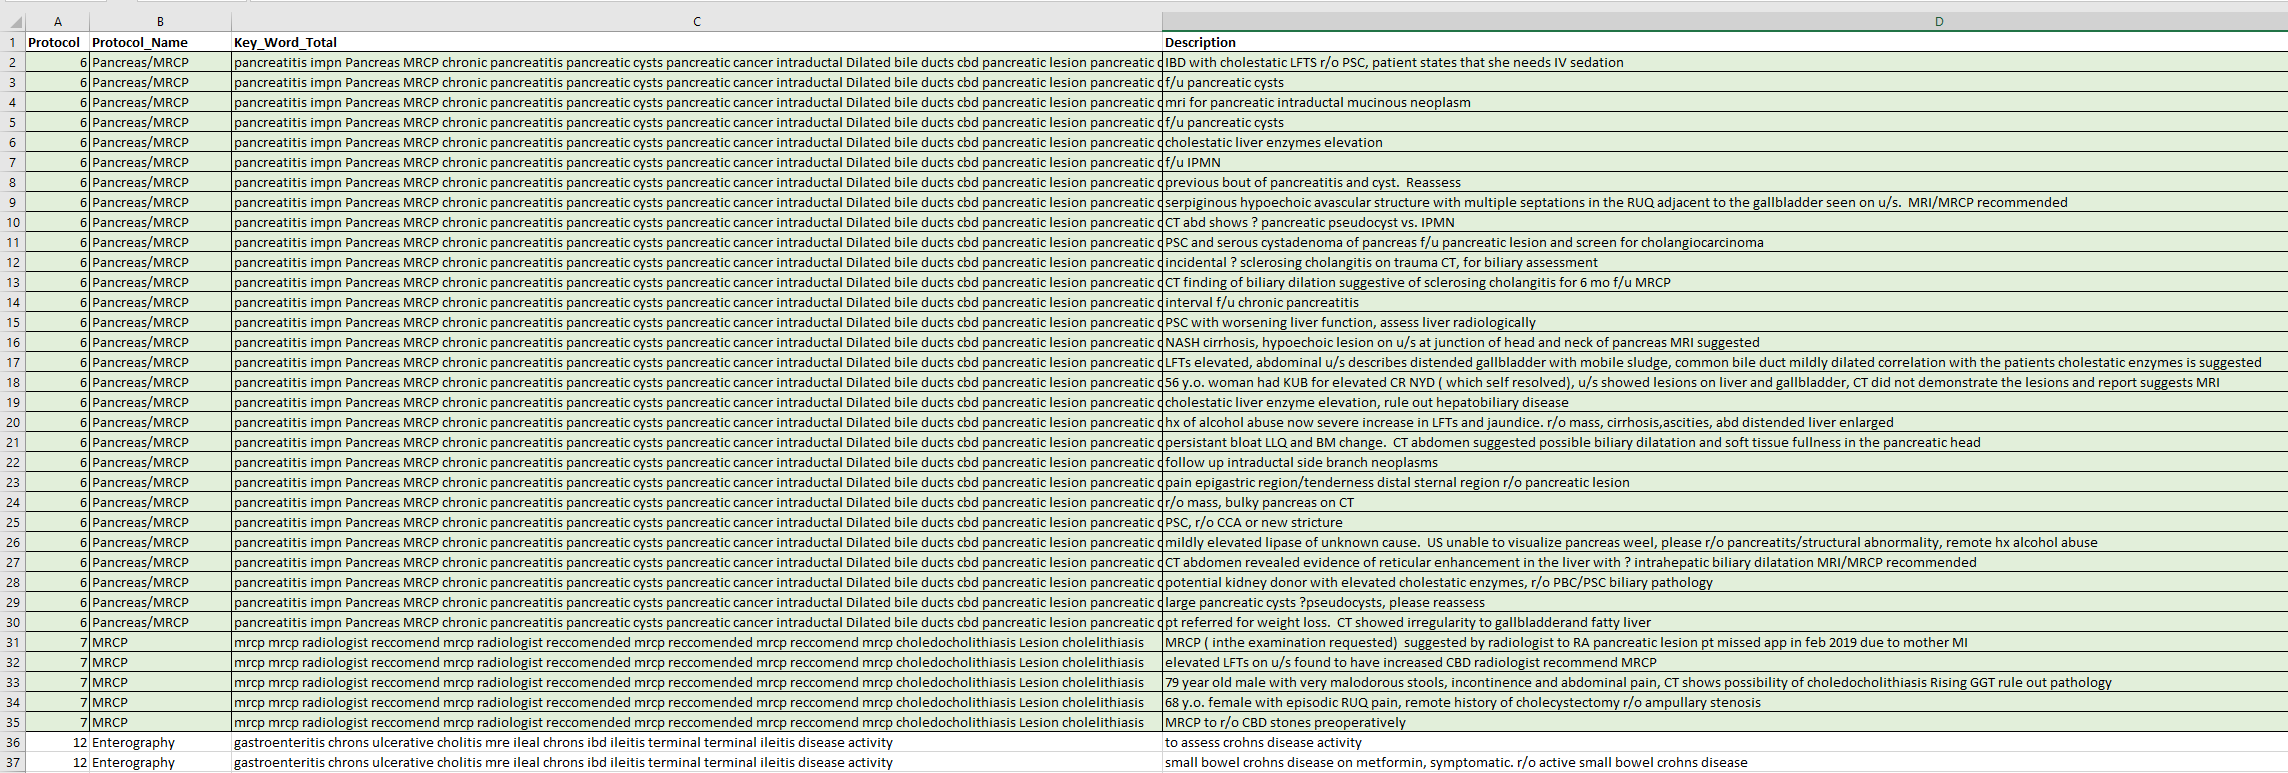

In [ ]:
def main(json, query):
    freq = []
    for key in query:
        try:
            tem = json[key]
            freq.append(tem)
        except Exception:
            pass

    score = sum(freq) / len(corpus)
    score = log10(len(corpus))
    
    return score

# Sample Query
json = {'investigation': 7, 'did': 3, 'campaign': 1, 'found': 1, 'said': 5, 'happen': 1, 'tara': 1, 'conclusion': 1, 'three': 1, 'former': 1, 'have': 1, 'reporting': 1, 'rebuked': 1, 'statement': 1, 'existence': 1, 'the': 1, 'as': 1, 'york': 1, 'our': 1, 'all': 1, 'new': 1, 'contemporaneously': 1, 'correctly': 1, 'news': 1, 'times': 1, 'of': 1, 'wednesday': 1, 'reported': 1, 'paper': 1, 'in': 1, 'allegation': 1, 'being': 1, 'biden': 1, 'prominent': 1, 'inaccurately': 1, 'or': 1, 'telling': 1, 'buzzfeed': 1, 'describe': 1, 'complained': 1, 'way': 1, 'for': 1, 'aides': 1, 'either': 1, 'accuser': 1, 'she': 1, 'spokesperson': 1, 'story': 1, 'to': 1, 'on': 1, 'incident': 1, 'points': 1, 'circulated': 1, 'by': 1, 'it': 1, 'been': 1, 'reade': 1, 'that': 1, 'whom': 1, 'no': 1, 'talking': 1, 'senate': 1, 'remember': 1, 'suggest': 1, 'fox': 1, 'democrats': 1, 'candidate': 1, 'made': 1, 'not': 1}
query = {'talk': 4, 'Biden': 2, 'campaign': 1, '': 2, 'News': 3, 'that': 2, 'the': 1, 'reported': 1, 'talking': 1, 'points': 1, 'have': 1}

score = main(json, query)
print("Score: ", score)

Score:  1.8388490907372552


##***Step #3) Custom Search using Key Word Total***

In [ ]:
abdomen_df = abdomen_df[['Protocol', 'Protocol_Name', 'Key_Word_Total']]

In [ ]:
abdomen_df

,Protocol,Protocol_Name,Key_Word_Total
0,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...
1,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...
2,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...
3,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...
4,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...
...,...,...,...
108,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...
109,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...
110,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...
111,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...


In [ ]:
abdomen_df2 = abdomen_df.drop_duplicates()

In [ ]:
abdomen_df2

,Protocol,Protocol_Name,Key_Word_Total
0,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...
42,6,Pancreas/MRCP,pancreatitis impn Pancreas MRCP chronic pancre...
71,7,MRCP,mrcp mrcp radiologist reccomend mrcp radiologi...
76,12,Enterography,gastroenteritis chrons ulcerative cholitis mre...
80,13,Prostate,psa enlarged prostate low grade high grade mid...
87,14,Female Pelvis,fibroids ovarion cyst entometroma ovarian canc...
101,19,Liver MRCP,cholestatic sclerosing cholangitis biliary scl...


In [ ]:
abdomen_df2.to_csv('/content/Protocol_to_Key_Word_Total_map.csv')

###***i) Example Using Abdomen Data***

In [ ]:
json_data = abdomen_df.Key_Word_Total.to_list()

In [ ]:
json_data

In [ ]:
json_data = set(json_data) # removed all duplicated strings 

In [ ]:
json_data = list(json_data) # enabled object mutability for data manipulation 

In [ ]:
json_data

['mets metastisis cirrohsis jaundice enlarged spleen hemangioma ascities LLQ pain RLQ pain URQ pain ULQ pain Cholestatic Mass liver lesions liver mass hcc lesions liver fatty liver hepatitis B neoplasm dysplastic nodule nodule nodules liver enzymes hypoechoic mass hbv lymph nodes serpiginous hypoechoic avascular multiple septations liver mets hepatoma hemangioma hbv liver transplant hypovascular lesion liver metastases elevated liver enzymes benign adenocarcinoma liver carcinoid lobe abscess Lesion psc lft lfts trauma acute abdominal pain cystic Cyst',
 'mrcp mrcp radiologist reccomend mrcp radiologist reccomended mrcp reccomended mrcp reccomend mrcp choledocholithiasis Lesion cholelithiasis',
 'pancreatitis impn Pancreas MRCP chronic pancreatitis pancreatic cysts pancreatic cancer intraductal Dilated bile ducts cbd pancreatic lesion pancreatic cyst multicystic pancreatic mucinous neoplasm tail pancreas head pseudocyst cholangiocarcinoma pancreatic body pancreatic mass pancreatic lesio

In [ ]:
resultant = []
for i in range(len(json_data)):
  print(f"'Text {i+1} {json_data[i]}'")

'Text 1 mets metastisis cirrohsis jaundice enlarged spleen hemangioma ascities LLQ pain RLQ pain URQ pain ULQ pain Cholestatic Mass liver lesions liver mass hcc lesions liver fatty liver hepatitis B neoplasm dysplastic nodule nodule nodules liver enzymes hypoechoic mass hbv lymph nodes serpiginous hypoechoic avascular multiple septations liver mets hepatoma hemangioma hbv liver transplant hypovascular lesion liver metastases elevated liver enzymes benign adenocarcinoma liver carcinoid lobe abscess Lesion psc lft lfts trauma acute abdominal pain cystic Cyst'
'Text 2 mrcp mrcp radiologist reccomend mrcp radiologist reccomended mrcp reccomended mrcp reccomend mrcp choledocholithiasis Lesion cholelithiasis'
'Text 3 pancreatitis impn Pancreas MRCP chronic pancreatitis pancreatic cysts pancreatic cancer intraductal Dilated bile ducts cbd pancreatic lesion pancreatic cyst multicystic pancreatic mucinous neoplasm tail pancreas head pseudocyst cholangiocarcinoma pancreatic body pancreatic mass 

In [ ]:
def get_top_matching_texts(texts, query, top_k=5):
    """
    texts (list): List of strings - in our case word bags that we use to generate our DB engine
    query (str): The query string to be compared against the DB engine we created.
    top_k (int, optional): The number of top matching texts to be returned - default is 5.
    """
    #a) conversion of text to machine understandable format
    nltk.download('punkt')
    vectorizer = TfidfVectorizer()
    corpus = texts + [query]  
    corpus_matrix = vectorizer.fit_transform(corpus)

    #b) finding the similarity score between query and list of texts/DB engine
    query_vector = corpus_matrix[-1] 
    similarity_scores = cosine_similarity(query_vector, corpus_matrix[:-1]) 
    similarity_scores = similarity_scores.flatten()
    top_indices = similarity_scores.argsort()[::-1][:top_k]

    #c) deliver results & similarity score 
    print(f"Top {top_k} Matching Protocol Diagnosis:\n")
    for i, index in enumerate(top_indices):
        similarity_score = similarity_scores[index]
        percentage_accuracy = similarity_score * 100
        print(f"{i+1}. Text {index+1}:")
        print(f"Cosine Similarity Score: {similarity_score:.4f}")
        print(f"Percentage Accuracy: {percentage_accuracy:.2f}%")
        print(texts[index])
        print("-----\n")


# This acts as our Database / Engine with which we will be able to make out predictions
texts = [ 
    'Text 1 gastroenteritis chrons ulcerative cholitis mre ileal chrons ibd ileitis terminal terminal ileitis disease activity',
    'Text 2 psa enlarged prostate low grade high grade mid grade prostate psa prostate lesions increasing psa negatice biopsy psa cryptorchidism hypodgonadism Lesion',
    'Text 3 mets metastisis cirrohsis jaundice enlarged spleen hemangioma ascities LLQ pain RLQ pain URQ pain ULQ pain Cholestatic Mass liver lesions liver mass hcc lesions liver fatty liver hepatitis B neoplasm dysplastic nodule nodule nodules liver enzymes hypoechoic mass hbv lymph nodes serpiginous hypoechoic avascular multiple septations liver mets hepatoma hemangioma hbv liver transplant hypovascular lesion liver metastases elevated liver enzymes benign adenocarcinoma liver carcinoid lobe abscess Lesion psc lft lfts trauma acute abdominal pain cystic Cyst',
    'Text 4 cholestatic sclerosing cholangitis biliary sclerosing cholangitis hepatic hemiangioma cholestatic enzymes psc lft lfts',
    'Text 5 mrcp mrcp radiologist reccomend mrcp radiologist reccomended mrcp reccomended mrcp reccomend mrcp choledocholithiasis Lesion cholelithiasis',
    'Text 6 pancreatitis impn Pancreas MRCP chronic pancreatitis pancreatic cysts pancreatic cancer intraductal Dilated bile ducts cbd pancreatic lesion pancreatic cyst multicystic pancreatic mucinous neoplasm tail pancreas head pseudocyst cholangiocarcinoma pancreatic body pancreatic mass pancreatic lesion ipmn Lesion cholelithiasis',
    'Text 7 fibroids ovarion cyst entometroma ovarian cancer dermoid fibrous tumour adnexal mass myometrium leiomyomas adenomyosis endometrial thickening endometrila polyps periods cervical ca ovarian endometrioma endometriotic adnexa pelvic pain invasive uterus ovaries ovary ca cervix complex pelvic mass pelvic mass dermoid endometrial cancer urethral diverticulum urethral menorrhagia adenomyosis paraovarian cysts endometriomas heavy periods ovarian cysts ovarian cervical mass abscess Cyst'
]

# This is the search we are making in order to find the most suitable protocol
query = "hepatic hemiangioma cholestatic entometroma ovarian cancer cholitis mre ileal chrons ibd ileitis LLQ" 

get_top_matching_texts(texts, query, top_k=5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Top 5 Matching Protocol Diagnosis:

1. Text 1:
Cosine Similarity Score: 0.4653
Percentage Accuracy: 46.53%
Text 1 gastroenteritis chrons ulcerative cholitis mre ileal chrons ibd ileitis terminal terminal ileitis disease activity
-----

2. Text 4:
Cosine Similarity Score: 0.2101
Percentage Accuracy: 21.01%
Text 4 cholestatic sclerosing cholangitis biliary sclerosing cholangitis hepatic hemiangioma cholestatic enzymes psc lft lfts
-----

3. Text 7:
Cosine Similarity Score: 0.1623
Percentage Accuracy: 16.23%
Text 7 fibroids ovarion cyst entometroma ovarian cancer dermoid fibrous tumour adnexal mass myometrium leiomyomas adenomyosis endometrial thickening endometrila polyps periods cervical ca ovarian endometrioma endometriotic adnexa pelvic pain invasive uterus ovaries ovary ca cervix complex pelvic mass pelvic mass dermoid endometrial cancer urethral diverticulum urethral menorrhagia adenomyosis paraovarian cysts endometriomas heavy periods ovarian cysts ovarian cervical mass abscess Cys




---





###***ii) Example Using MSK Data***

In [ ]:
json_data = msk_df.Key_Word_Total.to_list()

In [ ]:
json_data

In [ ]:
json_data = set(json_data) # removed all duplicated strings 

In [ ]:
json_data = list(json_data) # enabled object mutability for data manipulation 

In [ ]:
json_data

['rotaor cuff labrum glenoid bicepital groove acromian throwing RC tear rotator cuff tear cuff shoulder neuropathic shoulder impingement supraspinatous radiculopathy instability labral tear',
 'Tumour lipoma vs sarcoma lipoma sarcoma mass atypical mass osteomyelitis',
 'finger meta carpal',
 'avn hip',
 'ankle talar dome malleolus',
 'throwing elbow biceps tendon',
 'wrist TCLL carpal tunnel scaphiod carpal bones fell on wrist FOOSH ECU tendinopathy tfcc',
 'acl pcl mcl lcl meniscus knee osteoid meniscal tear meniscectomy buckling residual tear lateral joint medial pain anterior pain suprapatellar snap enchondroma lock neuropathic clicking instability crepitus meniscal injury anterior drawer test locked',
 'foot plantar fascitis cuboid heel cuboid metatarsal',
 "Mass osteochondroma enchondromas giant cell osteomas osteoid osteogenic sarcoma chondrosarcoma ewing's sarcoma malignant mets metastases enchondroma neoplasm cystic mass solid mass osteochondral lesion lesion osteochondral"]

In [ ]:
resultant = []
for i in range(len(json_data)):
  print(f"'Text {i+1} {json_data[i]}',")

'Text 1 rotaor cuff labrum glenoid bicepital groove acromian throwing RC tear rotator cuff tear cuff shoulder neuropathic shoulder impingement supraspinatous radiculopathy instability labral tear',
'Text 2 Tumour lipoma vs sarcoma lipoma sarcoma mass atypical mass osteomyelitis',
'Text 3 finger meta carpal',
'Text 4 avn hip',
'Text 5 ankle talar dome malleolus',
'Text 6 throwing elbow biceps tendon',
'Text 7 wrist TCLL carpal tunnel scaphiod carpal bones fell on wrist FOOSH ECU tendinopathy tfcc',
'Text 8 acl pcl mcl lcl meniscus knee osteoid meniscal tear meniscectomy buckling residual tear lateral joint medial pain anterior pain suprapatellar snap enchondroma lock neuropathic clicking instability crepitus meniscal injury anterior drawer test locked',
'Text 9 foot plantar fascitis cuboid heel cuboid metatarsal',
'Text 10 Mass osteochondroma enchondromas giant cell osteomas osteoid osteogenic sarcoma chondrosarcoma ewing's sarcoma malignant mets metastases enchondroma neoplasm cystic m

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_top_matching_texts(texts, query, top_k=5):
    """
    texts (list): List of strings - in our case word bags that we use to generate our DB engine
    query (str): The query string to be compared against the DB engine we created.
    top_k (int, optional): The number of top matching texts to be returned - default is 5.
    """
    #a) conversion of text to machine understandable format
    nltk.download('punkt')
    vectorizer = TfidfVectorizer()
    corpus = texts + [query]  
    corpus_matrix = vectorizer.fit_transform(corpus)

    #b) finding the similarity score between query and list of texts/DB engine
    query_vector = corpus_matrix[-1] 
    similarity_scores = cosine_similarity(query_vector, corpus_matrix[:-1]) 
    similarity_scores = similarity_scores.flatten()
    top_indices = similarity_scores.argsort()[::-1][:top_k]

    #c) deliver results & similarity score 
    print(f"Top {top_k} Matching Protocol Diagnosis:\n")
    for i, index in enumerate(top_indices):
        similarity_score = similarity_scores[index]
        percentage_accuracy = similarity_score * 100
        print(f"{i+1}. Text {index+1}:")
        print(f"Cosine Similarity Score: {similarity_score:.4f}")
        print(f"Percentage Accuracy: {percentage_accuracy:.2f}%")
        print(texts[index])
        print("-----\n")

# This acts as our Database / Engine with which we will be able to make out predictions
texts = [ 
'Text 1 acl pcl mcl lcl meniscus knee osteoid meniscal tear meniscectomy buckling residual tear lateral joint medial pain anterior pain suprapatellar snap enchondroma lock neuropathic clicking instability crepitus meniscal injury anterior drawer test locked',
'Text 2 Mass osteochondroma enchondromas giant cell osteomas osteoid osteogenic sarcoma chondrosarcoma ewings sarcoma malignant mets metastases enchondroma neoplasm cystic mass solid mass osteochondral lesion lesion osteochondral',
'Text 3 avn hip',
'Text 4 ankle talar dome malleolus',
'Text 5 throwing elbow biceps tendon',
'Text 6 rotaor cuff labrum glenoid bicepital groove acromian throwing RC tear rotator cuff tear cuff shoulder neuropathic shoulder impingement supraspinatous radiculopathy instability labral tear',
'Text 7 foot plantar fascitis cuboid heel cuboid metatarsal',
'Text 8 finger meta carpal',
'Text 9 Tumour lipoma vs sarcoma lipoma sarcoma mass atypical mass osteomyelitis',
'Text 10 wrist TCLL carpal tunnel scaphiod carpal bones fell on wrist FOOSH ECU tendinopathy tfcc'
]

# This is the search we are making in order to find the most suitable protocol
query = "wrist disease ileal chrons mass" 

get_top_matching_texts(texts, query, top_k=5)

Top 5 Matching Protocol Diagnosis:

1. Text 10:
Cosine Similarity Score: 0.1710
Percentage Accuracy: 17.10%
Text 10 wrist TCLL carpal tunnel scaphiod carpal bones fell on wrist FOOSH ECU tendinopathy tfcc
-----

2. Text 9:
Cosine Similarity Score: 0.1493
Percentage Accuracy: 14.93%
Text 9 Tumour lipoma vs sarcoma lipoma sarcoma mass atypical mass osteomyelitis
-----

3. Text 2:
Cosine Similarity Score: 0.1455
Percentage Accuracy: 14.55%
Text 2 Mass osteochondroma enchondromas giant cell osteomas osteoid osteogenic sarcoma chondrosarcoma ewings sarcoma malignant mets metastases enchondroma neoplasm cystic mass solid mass osteochondral lesion lesion osteochondral
-----

4. Text 8:
Cosine Similarity Score: 0.0000
Percentage Accuracy: 0.00%
Text 8 finger meta carpal
-----

5. Text 7:
Cosine Similarity Score: 0.0000
Percentage Accuracy: 0.00%
Text 7 foot plantar fascitis cuboid heel cuboid metatarsal
-----



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




---



###***iii) Example Using Brain Data***

In [ ]:
json_data = brain_df.Key_Word_Total.to_list()

In [ ]:
json_data

In [ ]:
json_data = set(json_data) # removed all duplicated strings 

In [ ]:
json_data = list(json_data) # enabled object mutability for data manipulation 

In [ ]:
json_data

[nan,
 'aneurysm f/u aneurysm aneurysm Ruptured coiling',
 'Migraine Headache GBM Glioblastoma Astrocytoma Oligodendroglioma glioma tumour resection subdural abscess lesion prognostication hydrocephalus mets metastatic intracranial mass SSS MVA MVC posterior fossa crainotomy gliosis edema ventriculostomy bells palsy neoplasm Hypothyroidism Cyst Glioblastoma Astrocytoma Oligodendroglioma glioma ischemia tumour cavernoma meningitis NF1 arachnoid cyst CVA ischemic Ependymoma Multiforme Lipoma Medulloblastoma Intracranial pressure Paralysis Agenesis corpus callosum Arachnoid cyst Dandy-walker syndrome Encephalocele Neurofibromatosis Tuberous sclerosis Adenoma sebaceum Sturgeon-Weber syndrome Hemiatrophy Hemianopsia Von hipped-lindau Angiomas Nystagmus Afebrile Cysticercosis headaches lymphoma encephalitis cns',
 'Migraine Headache LOC dizzieness weakness Vomiting Ataxia Nystagmus Personality change Delay Crainosynostosis Spasticity Microcephaly Mental retardation Lethargy Cranial size Port

In [ ]:
resultant = []
for i in range(len(json_data)):
  print(f"'Text {i+1} {json_data[i]}',")

'Text 1 nan',
'Text 2 aneurysm f/u aneurysm aneurysm Ruptured coiling',
'Text 3 Migraine Headache GBM Glioblastoma Astrocytoma Oligodendroglioma glioma tumour resection subdural abscess lesion prognostication hydrocephalus mets metastatic intracranial mass SSS MVA MVC posterior fossa crainotomy gliosis edema ventriculostomy bells palsy neoplasm Hypothyroidism Cyst Glioblastoma Astrocytoma Oligodendroglioma glioma ischemia tumour cavernoma meningitis NF1 arachnoid cyst CVA ischemic Ependymoma Multiforme Lipoma Medulloblastoma Intracranial pressure Paralysis Agenesis corpus callosum Arachnoid cyst Dandy-walker syndrome Encephalocele Neurofibromatosis Tuberous sclerosis Adenoma sebaceum Sturgeon-Weber syndrome Hemiatrophy Hemianopsia Von hipped-lindau Angiomas Nystagmus Afebrile Cysticercosis headaches lymphoma encephalitis cns',
'Text 4 Migraine Headache LOC dizzieness weakness Vomiting Ataxia Nystagmus Personality change Delay Crainosynostosis Spasticity Microcephaly Mental retardation 

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_top_matching_texts(texts, query, top_k=5):
    """
    texts (list): List of strings - in our case word bags that we use to generate our DB engine
    query (str): The query string to be compared against the DB engine we created.
    top_k (int, optional): The number of top matching texts to be returned - default is 5.
    """
    #a) conversion of text to machine understandable format
    nltk.download('punkt')
    vectorizer = TfidfVectorizer()
    corpus = texts + [query]  
    corpus_matrix = vectorizer.fit_transform(corpus)

    #b) finding the similarity score between query and list of texts/DB engine
    query_vector = corpus_matrix[-1] 
    similarity_scores = cosine_similarity(query_vector, corpus_matrix[:-1]) 
    similarity_scores = similarity_scores.flatten()
    top_indices = similarity_scores.argsort()[::-1][:top_k]

    #c) deliver results & similarity score 
    print(f"Top {top_k} Matching Protocol Diagnosis:\n")
    for i, index in enumerate(top_indices):
        similarity_score = similarity_scores[index]
        percentage_accuracy = similarity_score * 100
        print(f"{i+1}. Text {index+1}:")
        print(f"Cosine Similarity Score: {similarity_score:.4f}")
        print(f"Percentage Accuracy: {percentage_accuracy:.2f}%")
        print(texts[index])
        print("-----\n")

# This acts as our Database / Engine with which we will be able to make out predictions
texts = [ 
'Text 1 nan',
'Text 2 aneurysm f/u aneurysm aneurysm Ruptured coiling',
'Text 3 Migraine Headache GBM Glioblastoma Astrocytoma Oligodendroglioma glioma tumour resection subdural abscess lesion prognostication hydrocephalus mets metastatic intracranial mass SSS MVA MVC posterior fossa crainotomy gliosis edema ventriculostomy bells palsy neoplasm Hypothyroidism Cyst Glioblastoma Astrocytoma Oligodendroglioma glioma ischemia tumour cavernoma meningitis NF1 arachnoid cyst CVA ischemic Ependymoma Multiforme Lipoma Medulloblastoma Intracranial pressure Paralysis Agenesis corpus callosum Arachnoid cyst Dandy-walker syndrome Encephalocele Neurofibromatosis Tuberous sclerosis Adenoma sebaceum Sturgeon-Weber syndrome Hemiatrophy Hemianopsia Von hipped-lindau Angiomas Nystagmus Afebrile Cysticercosis headaches lymphoma encephalitis cns',
'Text 4 Migraine Headache LOC dizzieness weakness Vomiting Ataxia Nystagmus Personality change Delay Crainosynostosis Spasticity Microcephaly Mental retardation Lethargy Cranial size Port wine stain Memory loss Alzheimer Deficit headaches pseudotumour fatigue weakness',
'Text 5 seizure mesial temporal lobe epilepsy tonic clonic tle',
'Text 6 schwannoma cholesteatoma adenoma schwannoma Acoustic neuroma Neuroma Vestibular schwannoma Tinnitus Hearing loss Vertigo Sensory loss Craniopharyngioma tinnitis',
'Text 7 pituitary prolactinoma macroadenoma hyperprolactinemia Pituitary adenoma Rhinorrhea Loss of appetite Papilledema',
'Text 8 nyd'
]

# This is the search we are making in order to find the most suitable protocol
query = "Astrocytoma Migraine lobe Papilledema Memory loss" 

get_top_matching_texts(texts, query, top_k=5)

Top 5 Matching Protocol Diagnosis:

1. Text 7:
Cosine Similarity Score: 0.1687
Percentage Accuracy: 16.87%
Text 7 pituitary prolactinoma macroadenoma hyperprolactinemia Pituitary adenoma Rhinorrhea Loss of appetite Papilledema
-----

2. Text 4:
Cosine Similarity Score: 0.1565
Percentage Accuracy: 15.65%
Text 4 Migraine Headache LOC dizzieness weakness Vomiting Ataxia Nystagmus Personality change Delay Crainosynostosis Spasticity Microcephaly Mental retardation Lethargy Cranial size Port wine stain Memory loss Alzheimer Deficit headaches pseudotumour fatigue weakness
-----

3. Text 5:
Cosine Similarity Score: 0.1300
Percentage Accuracy: 13.00%
Text 5 seizure mesial temporal lobe epilepsy tonic clonic tle
-----

4. Text 3:
Cosine Similarity Score: 0.1000
Percentage Accuracy: 10.00%
Text 3 Migraine Headache GBM Glioblastoma Astrocytoma Oligodendroglioma glioma tumour resection subdural abscess lesion prognostication hydrocephalus mets metastatic intracranial mass SSS MVA MVC posterior fos

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
